Before we get started, a couple of reminders to keep in mind when using iPython notebooks:

- Remember that you can see from the left side of a code cell when it was last run if there is a number within the brackets.
- When you start a new notebook session, make sure you run all of the cells up to the point where you last left off. Even if the output is still visible from when you ran the cells in your previous session, the kernel starts in a fresh state so you'll need to reload the data, etc. on a new session.
- The previous point is useful to keep in mind if your answers do not match what is expected in the lesson's quizzes. Try reloading the data and run all of the processing steps one by one in order to make sure that you are working with the same variables and data that are at each quiz stage.


## Load Data from CSVs

In [42]:
import unicodecsv

## Longer version of code (replaced with shorter, equivalent version below)

# enrollments = []
# f = open('enrollments.csv', 'rb')
# reader = unicodecsv.DictReader(f)
# for row in reader:
#     enrollments.append(row)
# f.close()

with open('data/enrollments.csv', 'rb') as f:
    reader = unicodecsv.DictReader(f)
    enrollments = list(reader)

In [44]:
#####################################
#                 1                 #
#####################################

## Read in the data from daily_engagement.csv and project_submissions.csv 
## and store the results in the below variables.
## Then look at the first row of each table.
def load_data(filename):
    with open(filename, 'rb') as f:
        reader = unicodecsv.DictReader(f)
        return list(reader)
daily_engagement = load_data('data/daily_engagement.csv')
project_submissions = load_data('data/project_submissions.csv')


## Fixing Data Types

In [45]:
from datetime import datetime as dt

# Takes a date as a string, and returns a Python datetime object. 
# If there is no date given, returns None
def parse_date(date):
    if date == '':
        return None
    else:
        #print date
        return dt.strptime(date, '%Y-%m-%d')
    
# Takes a string which is either an empty string or represents an integer,
# and returns an int or None.
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

# Clean up the data types in the enrollments table
for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])
    
enrollments[0]

{u'account_key': u'448',
 u'cancel_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'days_to_cancel': 65,
 u'is_canceled': True,
 u'is_udacity': True,
 u'join_date': datetime.datetime(2014, 11, 10, 0, 0),
 u'status': u'canceled'}

In [46]:
# Clean up the data types in the engagement table
for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])
    
daily_engagement[0]

{u'acct': u'0',
 u'lessons_completed': 0,
 u'num_courses_visited': 1,
 u'projects_completed': 0,
 u'total_minutes_visited': 11.6793745,
 u'utc_date': datetime.datetime(2015, 1, 9, 0, 0)}

In [27]:
# Clean up the data types in the submissions table
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

project_submissions[0]

{u'account_key': u'256',
 u'assigned_rating': u'UNGRADED',
 u'completion_date': datetime.datetime(2015, 1, 16, 0, 0),
 u'creation_date': datetime.datetime(2015, 1, 14, 0, 0),
 u'lesson_key': u'3176718735',
 u'processing_state': u'EVALUATED'}

Note when running the above cells that we are actively changing the contents of our data variables. If you try to run these cells multiple times in the same session, an error will occur.

## Investigating the Data

In [47]:
#####################################
#                 2                 #
#####################################

## Find the total number of rows and the number of unique students (account keys)
## in each table.
unique_students = set([student['account_key'] for student in enrollments])
len(unique_students)

1302

## Problems in the Data

In [48]:
#####################################
#                 3                 #
#####################################

## Rename the "acct" column in the daily_engagement table to "account_key".
for engagement in daily_engagement:
    engagement['account_key'] = engagement['acct']
    del engagement['acct']
daily_engagement[0]['account_key']

u'0'

## Missing Engagement Records

In [60]:
#####################################
#                 4                 #
#####################################

## Find any one student enrollments where the student is missing from the daily engagement table.
## Output that enrollment.
unique_engagement = set([engagement['account_key'] for engagement in daily_engagement])
for student in enrollments:
    if student['account_key'] not in list(unique_engagement):
        print student
        break

{u'status': u'canceled', u'is_udacity': False, u'is_canceled': True, u'join_date': datetime.datetime(2014, 11, 12, 0, 0), u'account_key': u'1219', u'cancel_date': datetime.datetime(2014, 11, 12, 0, 0), u'days_to_cancel': 0}


## Checking for More Problem Records

In [61]:
#####################################
#                 5                 #
#####################################

## Find the number of surprising data points (enrollments missing from
## the engagement table) that remain, if any.
surprising_data = [student for student in enrollments if student['account_key'] not in list(unique_engagement)]
len([student for student in surprising_data if student['days_to_cancel'] > 0 or student['days_to_cancel'] == None])

3

## Tracking Down the Remaining Problems

In [55]:
# Create a set of the account keys for all Udacity test accounts
udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        udacity_test_accounts.add(enrollment['account_key'])
len(udacity_test_accounts)

6

In [62]:
# Given some data with an account_key field, removes any records corresponding to Udacity test accounts
def remove_udacity_accounts(data):
    non_udacity_data = []
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            non_udacity_data.append(data_point)
    return non_udacity_data

In [63]:
# Remove Udacity test accounts from all three tables
non_udacity_enrollments = remove_udacity_accounts(enrollments)
non_udacity_engagement = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)

print len(non_udacity_enrollments)
print len(non_udacity_engagement)
print len(non_udacity_submissions)

1622
135656
3634


## Refining the Question

In [65]:
#####################################
#                 6                 #
#####################################

## Create a dictionary named paid_students containing all students who either
## haven't canceled yet or who remained enrolled for more than 7 days. The keys
## should be account keys, and the values should be the date the student enrolled.

paid_students = {}
paid_submission = []
paid_engagement = []
paid_enrollment = []
for student in non_udacity_enrollments:
    if student['days_to_cancel'] is None or student['days_to_cancel'] > 7:
        if student['account_key'] not in paid_students or student['join_date'] > paid_students[student['account_key']]:
            paid_students[student['account_key']] = student['join_date']

for enrollment in non_udacity_enrollments:
    student = enrollment['account_key']
    if student in paid_students:
        paid_enrollment.append(enrollment)
        
for submission in non_udacity_submissions:
    student = submission['account_key']
    if student in paid_students:
        paid_submission.append(submission)
        
for engagement in non_udacity_engagement:
    student = engagement['account_key']
    if student in paid_students:
        paid_engagement.append(engagement)

print len(paid_enrollment)
print len(paid_engagement)
print len(paid_submission)
print len(paid_students)

1293
134549
3618
995


## Getting Data from First Week

In [79]:
# Takes a student's join date and the date of a specific engagement record,
# and returns True if that engagement record happened within one week
# of the student joining.
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days < 7 and time_delta.days>=0

In [80]:
#####################################
#                 7                 #
#####################################

## Create a list of rows from the engagement table including only rows where
## the student is one of the paid students you just found, and the date is within
## one week of the student's join date.
paid_engagement_in_first_week = []
for engagement in paid_engagement:
    student = engagement['account_key']
    engagement_date = engagement['utc_date']
    if student in paid_students:
        join_date = paid_students[student]
        if within_one_week(join_date, engagement_date):
            paid_engagement_in_first_week.append(engagement)

print len(paid_engagement_in_first_week)

6919


## Exploring Student Engagement

In [81]:
from collections import defaultdict

# Create a dictionary of engagement grouped by student.
# The keys are account keys, and the values are lists of engagement records.
engagement_by_account = defaultdict(list)
for engagement_record in paid_engagement_in_first_week:
    account_key = engagement_record['account_key']
    engagement_by_account[account_key].append(engagement_record)

In [82]:
# Create a dictionary with the total minutes each student spent in the classroom during the first week.
# The keys are account keys, and the values are numbers (total minutes)
total_minutes_by_account = {}
for account_key, engagement_for_student in engagement_by_account.items():
    total_minutes = 0
    for engagement_record in engagement_for_student:
        total_minutes += engagement_record['total_minutes_visited']
    total_minutes_by_account[account_key] = total_minutes

In [83]:
import numpy as np

# Summarize the data about minutes spent in the classroom
total_minutes = total_minutes_by_account.values()
print 'Mean:', np.mean(total_minutes)
print 'Standard deviation:', np.std(total_minutes)
print 'Minimum:', np.min(total_minutes)
print 'Maximum:', np.max(total_minutes)

Mean: 306.708326753
Standard deviation: 412.996933409
Minimum: 0.0
Maximum: 3564.7332645


## Debugging Data Analysis Code

In [84]:
#####################################
#                 8                 #
#####################################

## Go through a similar process as before to see if there is a problem.
## Locate at least one surprising piece of data, output it, and take a look at it.
problem_time = 0
problem_student = 0
for student, total_minutes in total_minutes_by_account.items():
    if total_minutes > problem_time:
        problem_time = total_minutes
        problem_student = student
print problem_time
print problem_student

total_minutes_by_account = {}
for account_key, engagement_for_student in engagement_by_account.items():
    total_minutes = 0
    for engagement_record in engagement_for_student:
        delta = engagement_record['utc_date'] - paid_students[account_key]
        if delta.days >= 0:
            total_minutes += engagement_record['total_minutes_visited']
    total_minutes_by_account[account_key] = total_minutes

total_minutes = total_minutes_by_account.values()
print 'Mean:', np.mean(total_minutes)
print 'Standard deviation:', np.std(total_minutes)
print 'Minimum:', np.min(total_minutes)
print 'Maximum:', np.max(total_minutes)

3564.7332645
163
Mean: 306.708326753
Standard deviation: 412.996933409
Minimum: 0.0
Maximum: 3564.7332645


## Lessons Completed in First Week

In [85]:
#####################################
#                 9                 #
#####################################

## Adapt the code above to find the mean, standard deviation, minimum, and maximum for
## the number of lessons completed by each student during the first week. Try creating
## one or more functions to re-use the code above.
def find_total(data, key):
    total_by_account = {}
    for account_key, engagement_for_student in data.items():
        total = 0
        for engagement_record in engagement_for_student:
            delta = engagement_record['utc_date'] - paid_students[account_key]
            if delta.days >= 0:
                total += engagement_record[key]
        total_by_account[account_key] = total
    return total_by_account

total_lessons_by_account = find_total(engagement_by_account,'lessons_completed')
total_lessons = total_lessons_by_account.values()
print 'Mean:', np.mean(total_lessons)
print 'Standard deviation:', np.std(total_lessons)
print 'Minimum:', np.min(total_lessons)
print 'Maximum:', np.max(total_lessons)

Mean: 1.63618090452
Standard deviation: 3.00256129983
Minimum: 0
Maximum: 36


## Number of Visits in First Week

In [86]:
######################################
#                 10                 #
######################################

## Find the mean, standard deviation, minimum, and maximum for the number of
## days each student visits the classroom during the first week.
for engagement in non_udacity_engagement:
    if engagement['num_courses_visited'] > 0:
        engagement['has_visited'] = 1
    else:
        engagement['has_visited'] = 0
        
total_days_by_account = find_total(engagement_by_account, 'has_visited')
total_days = total_days_by_account.values()
print 'Mean:', np.mean(total_days)
print 'Standard deviation:', np.std(total_days)
print 'Minimum:', np.min(total_days)
print 'Maximum:', np.max(total_days)

Mean: 2.86733668342
Standard deviation: 2.25519800292
Minimum: 0
Maximum: 7


## Splitting out Passing Students

In [87]:
######################################
#                 11                 #
######################################

## Create two lists of engagement data for paid students in the first week.
## The first list should contain data for students who eventually pass the
## subway project, and the second list should contain data for students
## who do not.

subway_project_lesson_keys = ['746169184', '3176718735']

passing_engagement = []
non_passing_engagement = []

passed_student = set()
for submission in paid_submission:
    rating = submission['assigned_rating']
    lesson = submission['lesson_key']
    student = submission['account_key']
    if lesson in subway_project_lesson_keys and rating in ['PASSED', 'DISTINCTION']:
        passed_student.add(student)

for engagement in paid_engagement_in_first_week:
    student = engagement['account_key']
    if student in passed_student:
        passing_engagement.append(engagement)
    else:
        non_passing_engagement.append(engagement)

print len(passed_student)
print len(passing_engagement)
print len(non_passing_engagement)

647
4527
2392


## Comparing the Two Student Groups

In [88]:
######################################
#                 12                 #
######################################

## Compute some metrics you're interested in and see how they differ for
## students who pass the subway project vs. students who don't. A good
## starting point would be the metrics we looked at earlier (minutes spent
## in the classroom, lessons completed, and days visited).
def group_data(data):
    data_by_account = defaultdict(list)
    for data_point in data:
        account_key = data_point['account_key']
        data_by_account[account_key].append(data_point)
    return data_by_account

passing_engagement_by_account = group_data(passing_engagement)
non_passing_engagement_by_account = group_data(non_passing_engagement)

def print_statistics(data, key):
    total_data_by_account = find_total(data, key)
    total = total_data_by_account.values()
    print 'Mean:', np.mean(total)
    print 'Standard deviation:', np.std(total)
    print 'Minimum:', np.min(total)
    print 'Maximum:', np.max(total)

print "===Passing Engagement==="
print_statistics(passing_engagement_by_account, 'total_minutes_visited')
print "===Non Passing Engagement==="
print_statistics(non_passing_engagement_by_account, 'total_minutes_visited')

===Passing Engagement===
Mean: 394.586046484
Standard deviation: 448.499519327
Minimum: 0.0
Maximum: 3564.7332645
===Non Passing Engagement===
Mean: 143.326474267
Standard deviation: 269.538619011
Minimum: 0.0
Maximum: 1768.52274933


## Making Histograms

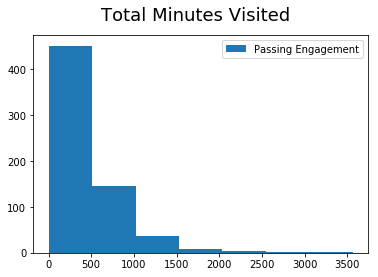

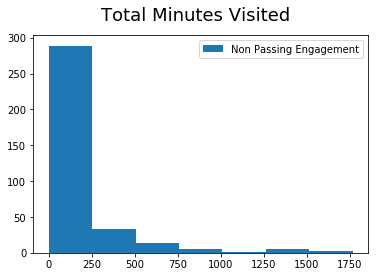

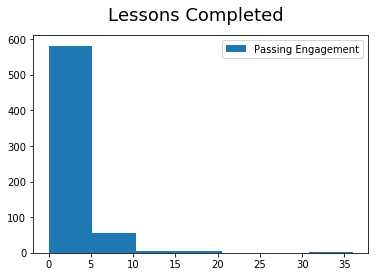

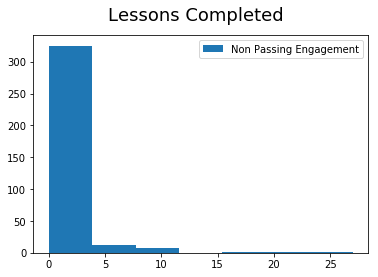

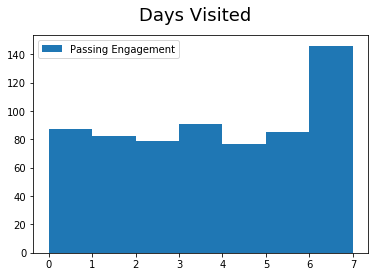

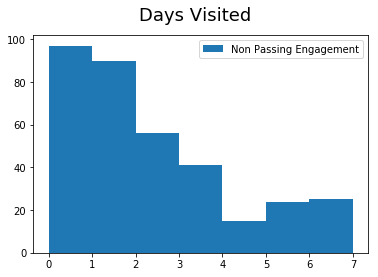

In [105]:
######################################
#                 13                 #
######################################

## Make histograms of the three metrics we looked at earlier for both
## students who passed the subway project and students who didn't. You
## might also want to make histograms of any other metrics you examined.
import matplotlib.pyplot as plt
def print_histogram(data, key, label):
    total_data_by_account = find_total(data, key)
    total = total_data_by_account.values()
    plt.hist(total, bins=7, label=label)
    plt.legend()
    plt.show()

plt.figure()
plt.suptitle('Total Minutes Visited', fontsize=18)
print_histogram(passing_engagement_by_account, 'total_minutes_visited', 'Passing Engagement')
plt.figure()
plt.suptitle('Total Minutes Visited', fontsize=18)
print_histogram(non_passing_engagement_by_account, 'total_minutes_visited', 'Non Passing Engagement')
plt.figure()
plt.suptitle('Lessons Completed', fontsize=18)
print_histogram(passing_engagement_by_account, 'lessons_completed', 'Passing Engagement')
plt.figure()
plt.suptitle('Lessons Completed', fontsize=18)
print_histogram(non_passing_engagement_by_account, 'lessons_completed', 'Non Passing Engagement')
plt.figure()
plt.suptitle('Days Visited', fontsize=18)
print_histogram(passing_engagement_by_account, 'has_visited', 'Passing Engagement')
plt.figure()
plt.suptitle('Days Visited', fontsize=18)
print_histogram(non_passing_engagement_by_account, 'has_visited', 'Non Passing Engagement')

## Improving Plots and Sharing Findings

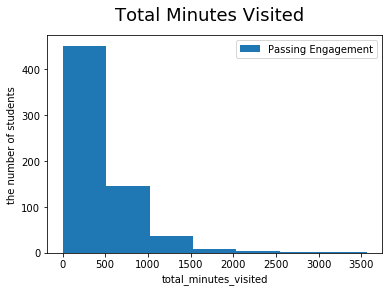

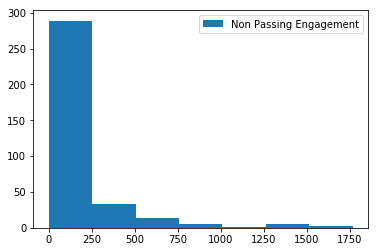

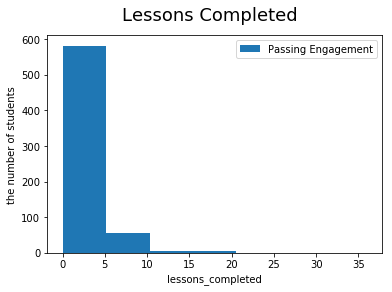

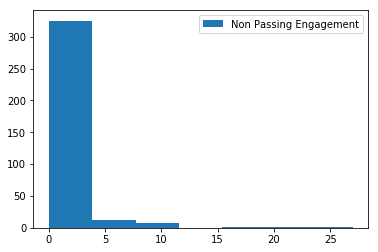

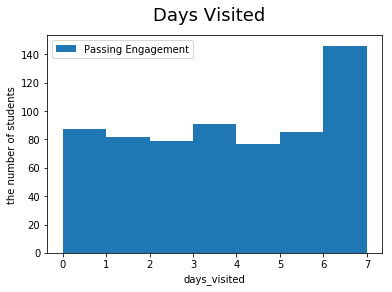

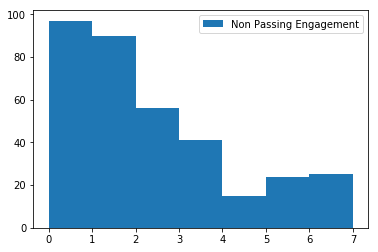

In [106]:
######################################
#                 14                 #
######################################

## Make a more polished version of at least one of your visualizations
## from earlier. Try importing the seaborn library to make the visualization
## look better, adding axis labels and a title, and changing one or more
## arguments to the hist() function.
plt.figure()
plt.suptitle('Total Minutes Visited', fontsize=18)
plt.xlabel("total_minutes_visited")
plt.ylabel("the number of students")
print_histogram(passing_engagement_by_account, 'total_minutes_visited', 'Passing Engagement')
print_histogram(non_passing_engagement_by_account, 'total_minutes_visited', 'Non Passing Engagement')

plt.figure()
plt.suptitle('Lessons Completed', fontsize=18)
plt.xlabel("lessons_completed")
plt.ylabel("the number of students")
print_histogram(passing_engagement_by_account, 'lessons_completed', 'Passing Engagement')
print_histogram(non_passing_engagement_by_account, 'lessons_completed', 'Non Passing Engagement')

plt.figure()
plt.suptitle('Days Visited', fontsize=18)
plt.xlabel("days_visited")
plt.ylabel("the number of students")
print_histogram(passing_engagement_by_account, 'has_visited', 'Passing Engagement')
print_histogram(non_passing_engagement_by_account, 'has_visited', 'Non Passing Engagement')